### Experiments for Reconstruction of networks using scoring with LSM or with random additions.

In [ ]:
# Ensure necessary packages are installed
!pip install cobra efmtool numpy pandas scipy

COBRApy Definition of the SK Network from Szallasi's "A first course in Systems Biology"

In [1]:
from cobra import Model, Reaction, Metabolite

# Modell erstellen
model = Model("Simple_Network")

# Metaboliten definieren
A_EX = Metabolite("A_EX", compartment="e")
B_EX = Metabolite("B_EX", compartment="e")
P_EX = Metabolite("P_EX", compartment="e")
E_EX = Metabolite("E_EX", compartment="e")
A = Metabolite("A", compartment="c")
B = Metabolite("B", compartment="c")
C = Metabolite("C", compartment="c")
D = Metabolite("D", compartment="c")
E = Metabolite("E", compartment="c")
P = Metabolite("P", compartment="c")


# Reaktionen definieren
r1 = Reaction("A_in")
r1.name = "r1"
r1.lower_bound = 0.0
r1.upper_bound = 1000.0
r1.add_metabolites({A_EX: -1, A: 1})

r2 = Reaction("B_in_out")
r2.name = "r2"
r2.lower_bound = -1000.0
r2.upper_bound = 1000.0
r2.add_metabolites({B_EX: -1, B: 1})

r3 = Reaction("P_out")
r3.name = "r3"
r3.lower_bound = 0.0
r3.upper_bound = 1000.0
r3.add_metabolites({P: -1, P_EX: 1})

r4 = Reaction("E_out")
r4.name = "r4"
r4.lower_bound = 0.0
r4.upper_bound = 1000.0
r4.add_metabolites({E_EX: 1, E: -1})

r5 = Reaction("r5")
r5.name = "r5"
r5.lower_bound = 0.0
r5.upper_bound = 1000.0
r5.add_metabolites({A: -1, B: 1})

r6 = Reaction("r6")
r6.name = "r6"
r6.lower_bound = 0.0
r6.upper_bound = 1000.0
r6.add_metabolites({A: -1, C: 1})

r7 = Reaction("r7")
r7.name = "r7"
r7.lower_bound = 0.0
r7.upper_bound = 1000.0
r7.add_metabolites({A: -1, D: 1})

r8 = Reaction("r8")
r8.name = "r8"
r8.lower_bound = -1000.0
r8.upper_bound = 1000.0
r8.add_metabolites({B: -1, C: 1})

r9 = Reaction("r9")
r9.name = "r9"
r9.lower_bound = 0.0
r9.upper_bound = 1000.0
r9.add_metabolites({B: -1, P: 1})

r10 = Reaction("r10")
r10.name = "r10"
r10.lower_bound = 0.0
r10.upper_bound = 1000.0
r10.add_metabolites({C: -1, D: -1, P: 1, E: 1})


# Reaktionen zum Modell hinzufügen
model.add_reactions([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10])

# Modell überprüfen
print("Reaktionen:", [rxn.id for rxn in model.reactions])
print("Metaboliten:", [met.id for met in model.metabolites])
print("Gene:", [gene.id for gene in model.genes])




Reaktionen: ['A_in', 'B_in_out', 'P_out', 'E_out', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10']
Metaboliten: ['A_EX', 'A', 'B_EX', 'B', 'P', 'P_EX', 'E_EX', 'E', 'C', 'D']
Gene: []


Method to retrieve the stochiometric matrix of a COBRApy model.

In [91]:
import numpy as np
import cobra


def get_stoichiometric_matrix(model):
    # Filtere die Reaktionen, um nur Reaktionen zu behalten, die nicht mit "EX_" beginnen
    internal_reactions = [rxn for rxn in model.reactions if not rxn.id.startswith("EX_")]

    # Extrahiere die Metaboliten aus dem Modell
    internal_metabolites = [meta for meta in model.metabolites if not meta.compartment == 'e']

    # Erstelle die leere Stöchiometrie-Matrix mit (Anzahl der Metaboliten, Anzahl der internen Reaktionen)
    stoichiometric_matrix = np.zeros((len(internal_metabolites), len(internal_reactions)))

    # Befülle die Stöchiometrie-Matrix so, dass jede Spalte eine Reaktion repräsentiert
    for j, rxn in enumerate(internal_reactions):  # Spaltenweise über Reaktionen iterieren
        for i, met in enumerate(internal_metabolites):  # Zeilenweise über Metaboliten iterieren
            stoichiometric_matrix[i, j] = rxn.metabolites.get(met, 0)  # Falls Metabolit nicht in der Reaktion ist, wird 0 zurückgegeben
    return stoichiometric_matrix


In [3]:
stoichiometry=get_stoichiometric_matrix(model)
print("Stoichiometric matrix shape:", stoichiometry.shape)
print("Stoichiometric matrix:", stoichiometry)


Stoichiometric matrix shape: (6, 10)
Stoichiometric matrix: [[ 1.  0.  0.  0. -1. -1. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -1. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]]


Method to calculate the Elementary Flux Modes for a COBRApy model

In [4]:
import efmtool
import cobra
import numpy as np
from efmtool import calculate_efms

def cobra_to_efms(model):
    # 1. Stoichiometric matrix (S matrix)
    metabolites = [
    metabolite for metabolite in model.metabolites 
    if metabolite.compartment == "c"
    ]
    reactions = model.reactions
    stoichiometry = np.zeros((len(metabolites), len(reactions)))
    #stoichiometry = get_stoichiometric_matrix(model)
    
    for i, met in enumerate(metabolites):
        for j, rxn in enumerate(reactions):
            try:
                stoichiometry[i, j] = rxn.get_coefficient(met.id)
            except KeyError:
                
                stoichiometry[i, j] = 0.0
    
    print("Stoichiometric matrix shape:", stoichiometry.shape)
    print("Stoichiometric matrix:", stoichiometry)

    # 2. Reversibilities: 1 for reversible, 0 for irreversible reactions
    reversibilities = [1 if rxn.reversibility else 0 for rxn in reactions]
    
    print("Reversibilities:", reversibilities)
    print("Number of reactions:", len(reactions))

    # 3. Reaction names
    reaction_names = [rxn.id for rxn in reactions]
    
    # 4. Metabolite names
    metabolite_names = [met.id for met in metabolites]
    
    return calculate_efms(stoichiometry, reversibilities, reaction_names, metabolite_names), reaction_names




# 6. Berechne die Elementarmoden (EFMs) mit dem efmtool und Reaktionsnamen
efms, reaction_names = cobra_to_efms(model)

# 7. Ergebnisse anzeigen
print("Berechnete Elementarmoden:")
print(np.column_stack((reaction_names, efms)))


Stoichiometric matrix shape: (6, 10)
Stoichiometric matrix: [[ 1.  0.  0.  0. -1. -1. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -1. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]]
Reversibilities: [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Number of reactions: 10
2024-12-31  16:27:07.923  main                     INFO     | logger initialized
2024-12-31  16:27:07.924  main                     INFO     | =====================================================
2024-12-31  16:27:07.924  main                     INFO     | efmtool version 4.7.1, 2009-12-04 18:30:05
2024-12-31  16:27:07.924  main                     INFO     | Copyright (c) 2009, Marco Terzer, Zurich, Switzerland
2024-12-31  16:27:07.924  main                     INFO     | This is free software, !!! NO WARRANTY !!!
2024-12-31  16:27:07.924  main                     INFO     | See LICENCE.txt for redi

Definition of the Datapoints from Elementary Flux Modes

In [5]:
import numpy as np


input_array = np.column_stack((reaction_names, efms))

# Extract headers and values
headers = input_array[:, 0]
values = input_array[:, 1:].astype(float)  # Convert values to float

# Construct dictionaries
experimental_data = []
for col_idx in range(values.shape[1]):
    data_point = {}
    for row_idx, header in enumerate(headers):
        if header.endswith("_in") or header.endswith("_out"):
            # Add only reactions ending with "_in" or "_out"
            data_point[header] = values[row_idx, col_idx]
    # Normalize so "A_in" is always 1.0
    if "A_in" in data_point and data_point["A_in"] != 0.0:
        normalization_factor = data_point["A_in"]
        for key in data_point.keys():
            data_point[key] /= normalization_factor
    else:
        if ("B_in_out" in data_point and data_point["B_in_out"] > 0):
            normalization_factor = data_point["B_in_out"]
            for key in data_point.keys():
                data_point[key] /= normalization_factor
        
    experimental_data.append(data_point)

# Output the result
for data in experimental_data:
    print(data)

experimental_data_zeropadded_out = experimental_data

{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}
{'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}
{'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}


Method to calculate the Fit-Score of a model for some experimental data

In [63]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import minimize





#print(reaction_ids)
# Funktion zur Ableitung des Zielvektors aus den experimentellen Daten
def create_target_vector(data_point, reaction_ids):
    target_flux = np.full(len(reaction_ids), np.nan)  # Vektor mit NaN initialisieren
    for rxn_id, value in data_point.items():
        if rxn_id in reaction_ids:  # Nur Reaktionen, die im Modell existieren
            idx = reaction_ids.index(rxn_id)
            target_flux[idx] = value  # Setze den Zielwert
    return target_flux


def least_square_min(model, S, experimental_data):
    reaction_ids = [rxn.id for rxn in model.reactions if not rxn.id.startswith("EX_")]
    total_score = 0.0
    successful_optimizations = 0

    for data_point in experimental_data:
        # Zielvektor für aktuellen Datenpunkt erstellen
        target_flux = create_target_vector(data_point, reaction_ids)

        # Filter für bekannte Flüsse (Reaktionen, die in 'target_flux' nicht NaN sind)
        known_flux_indices = ~np.isnan(target_flux)
        target_flux_values = target_flux[known_flux_indices]

        def objective(x):
            return np.linalg.norm(x[known_flux_indices] - target_flux_values)

        constraints = {'type': 'eq', 'fun': lambda x: np.dot(S, x)}

        initial_guess = np.zeros(len(reaction_ids))
        bounds = [(model.reactions.get_by_id(rxn_id).lower_bound,
                   model.reactions.get_by_id(rxn_id).upper_bound)
                  for rxn_id in reaction_ids]

        result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds, tol=1e-10)

        if result.success:
            optimized_flux = result.x
            total_score += np.linalg.norm(optimized_flux[known_flux_indices] - target_flux_values)
            successful_optimizations += 1
        else:
            print(f"Optimization failed for data point: {data_point}. Message: {result.message}")

    # Return None if any optimization failed, otherwise the total score
    if successful_optimizations < len(experimental_data):
        return 0.0, len(experimental_data)
    else:
        return total_score, len(experimental_data)

 
S = get_stoichiometric_matrix(model)
print(least_square_min(model, S, experimental_data_zeropadded_out))

(9.48783837897229e-07, 8)


Method to generate random reactions for metabolites from the model.

In [74]:
import random
from cobra import Reaction

# Erstellen von Reaktionen mit 1-2 Substrat(en) und 1-2 Produkt(en)
def generate_random_reactions(model, num_reactions=2000):
    # Filter out metabolites that end with '_EX'
    metabolites = [met for met in model.metabolites if not met.compartment == 'e']
    random_reactions = []

    for i in range(num_reactions):
        reaction_valid = False

        while not reaction_valid:
            # Zufällige Auswahl der Anzahl an Substraten und Produkten
            num_reactants = random.randint(1, 2)
            num_products = random.randint(1, 2)

            # Zufällige Auswahl der Substrate und Produkte
            reactants = random.sample(metabolites, num_reactants)
            products = random.sample(metabolites, num_products)

            # Check, dass auf beiden Seiten Metaboliten vorhanden sind
            if set(reactants).isdisjoint(set(products)):
                reaction_valid = True

                # Erstellung der Reaktion
                reaction = Reaction(f'Random_Rxn_{i+1}')
                reaction.name = f'Random Reaction {i+1}'

                reaction.add_metabolites({
                    met: -1.0 for met in reactants
                })
                reaction.add_metabolites({
                    met: 1.0 for met in products
                })

                # 50% Chance, die Reaktion reversibel zu machen
                if random.random() < 0.5:
                    reaction.lower_bound = -1000.0
                else:
                    reaction.lower_bound = 0.0

                reaction.upper_bound = 1000.0

                random_reactions.append(reaction)

    return random_reactions

# Generierung von 2000 zufälligen Reaktionen + den Inversen
random_reactions_list = generate_random_reactions(model, num_reactions=2000)

# Anzahl der insgesamt generierten Reaktionen
print(f"\nTotal number of random reactions generated: {len(random_reactions_list)}")


Total number of random reactions generated: 2000


Methods to sample reactions (either from a model or from a list):

In [9]:
import cobra
import random

def sample_reactions(model, n_reactions):
   
    # Filter reactions that do not end with '_in' or '_out'
    valid_reactions = [rxn for rxn in model.reactions if not rxn.id.endswith('_in') and not rxn.id.endswith('_out')]

    # Ensure that the model has enough valid reactions
    if n_reactions > len(valid_reactions):
        raise ValueError("Requested number of reactions exceeds the total number of valid reactions in the model")

    # Sample reactions randomly from the valid reactions list
    sampled_reactions = random.sample(valid_reactions, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id)
    
    return sampled_reactions


In [10]:
import random

def sample_reactions_from_list(reactions_list, n_reactions):
    
    # Ensure the list has enough reactions to sample from
    if n_reactions > len(reactions_list):
        raise ValueError("Requested number of reactions exceeds the total number of reactions in the list")

    # Sample reactions randomly from the given list
    sampled_reactions = random.sample(reactions_list, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id if hasattr(rxn, 'id') else rxn)  # Print the ID if the object has one

    return sampled_reactions


Method to calculate the Model-Score between two models.

In [11]:
def model_edit_distance(model1, model2):
    
    # Get sets of reaction IDs for both models
    reactions_model1 = {rxn.id for rxn in model1.reactions}
    reactions_model2 = {rxn.id for rxn in model2.reactions}
    
    # Calculate the symmetric difference (reactions present in one model but not the other)
    differing_reactions = reactions_model1.symmetric_difference(reactions_model2)
    
    # The edit distance is the number of differing reactions
    edit_distance = len(differing_reactions)
    
    return edit_distance




In [12]:
import pandas as pd

def filter_and_display(list1, list2, list3):
    
    # Erstellen des DataFrames
    df = pd.DataFrame({'Scores': list1, 'Edit Distances': list2, 'Computation Count': list3})
    
    # Filtern: Entfernen von Zeilen mit NaN oder 0.0 in der ersten Liste
    filtered_df = df.dropna(subset=['Scores'])
    filtered_df = filtered_df[filtered_df['Scores'] != 0.0]
    
    # Ergebnis zurückgeben oder anzeigen
    return filtered_df




Method to search reaction with best score after addition to a model.

In [62]:
def score_reaction_lsm(model, reaction, experimental_data):
    # Kopiere das Modell und füge die Reaktion hinzu
    with model:
        model.add_reactions([reaction])
        S = get_stoichiometric_matrix(model)
        score, _ = least_square_min(model, S, experimental_data)
    return score

def add_best_reaction_lsm_chance_random(original_model, experimental_data, random_reactions_list, max_iterations=1):
    # Kopiere das Modell
    model = original_model.copy()

    ccs = 0

    S = get_stoichiometric_matrix(model)
    ini_score, cc = least_square_min(model, S, experimental_data)
    ccs += cc
    print(f"Score before addition: {ini_score}")
    if ini_score == 0.0:
        print(f"Model not solvable: {ini_score}")
        return ini_score, original_model, ccs

    iteration = 0
    while ini_score > 0 and iteration < max_iterations:
        if not random_reactions_list:
            print("No more random reactions to add.")
            break

        # Scoring der Reaktionen
        reaction_scores = {
            reaction.id: score
            for reaction in random_reactions_list
            if (score := score_reaction_lsm(model, reaction, experimental_data)) < ini_score and score > 0.0
        }
        ccs += len(experimental_data) * len(random_reactions_list)

        # Auswahl der besten Reaktion basierend auf dem Score
        if reaction_scores:
            best_reaction_id = min(reaction_scores, key=reaction_scores.get)

            best_reaction = next(r for r in random_reactions_list if r.id == best_reaction_id)
            ini_score = reaction_scores[best_reaction_id]

            print(f"Adding reaction: {best_reaction.id} with score: {reaction_scores[best_reaction_id]}")
            model.add_reactions([best_reaction])
            random_reactions_list.remove(best_reaction)
        else:
            print("No reactions with improvements found")
            break

        iteration += 1

    return ini_score, model, ccs

Reconstruction algorithm:

In [16]:
import time
import numpy as np
import random

def evaluate_score_random_evolution(test_model, experimental_data, sampling_size, num_iterations, chance_random):
    min_value = 0.0
    max_value = 1.0

    # Validate the `chance_random` parameter
    if not (min_value <= chance_random <= max_value):
        raise ValueError(f"Argument 'chance_random' must be between {min_value} and {max_value}. Given: {chance_random}")
    
    scores = np.zeros(num_iterations)
    edit_distances = np.zeros(num_iterations)
    counts_computations = np.zeros(num_iterations)
    score_evolutions = []  # To store the evolution of scores for each iteration
    
    for i in range(num_iterations):
        count_computations = 0
        
        # Step 1: Copy model and remove reactions
        model = test_model.copy()
        
        reactions_to_remove = sample_reactions(model, sampling_size)
        removed_reactions = [model.reactions.get_by_id(reaction.id) for reaction in reactions_to_remove]
        model.remove_reactions(reactions_to_remove)
        random_reactions = generate_random_reactions(model, 50)
        random_reactions.extend(removed_reactions)  # Include removed reactions in the pool
        input_model = model.copy()
        # Step 2: Initial score computation
        S = get_stoichiometric_matrix(model)
        score, cc = least_square_min(model, S, experimental_data)
        count_computations += cc
        if score == 0.0:
            score = 1000.0
        
        # Track the evolution of scores
        score_evolution = [score]  # Start with the initial score
        
        # Step 3: Modify model until score meets criteria
        while score > 3e-7:
            decision_value = random.uniform(0.0, 1.0)
            if decision_value < chance_random:
                # Add a random reaction
                random_reaction = random.choice(random_reactions)
                model.add_reactions([random_reaction])
                random_reactions.remove(random_reaction)
            else:
                # Add the best reaction based on LSM
                score, model, cc = add_best_reaction_lsm_chance_random(model, experimental_data, random_reactions)
                count_computations += cc
            
            # Recompute the score
            S = get_stoichiometric_matrix(model)
            score, cc = least_square_min(model, S, experimental_data)
            count_computations += cc
            # Track the score after each addition
            score_evolution.append(score)
            
        
        # Step 4: Store final results
        scores[i] = score if score != 0.0 else None
        edit_distance = model_edit_distance(input_model, model)
        edit_distances[i] = edit_distance
        
        
        counts_computations[i] = count_computations
        
        # Store the score evolution for this iteration
        score_evolutions.append(score_evolution)
        
        
        print(filter_and_display(scores, edit_distances, counts_computations))
    
    # Return all results, including score evolutions
    return scores, edit_distances, counts_computations, score_evolutions


In [17]:
import pandas as pd

def display4(list1, list2, list3, list4):
   
    # Erstellen des DataFrames
    df = pd.DataFrame({'Scores': list1, 'Edit Distances': list2, 'Number of LSQ Computations': list3, 'Score Evolutions': list4})
    
    # Filtern: Entfernen von Zeilen mit NaN oder 0.0 in der ersten Liste
    filtered_df = df.dropna(subset=['Scores'])
    filtered_df = filtered_df[filtered_df['Scores'] != 0.0]
    
    # Ergebnis zurückgeben oder anzeigen
    return filtered_df


Example Usage:

In [28]:
result_dataframes_with_ct = []

for i in range(11):
    scores, edit_distances, computation_times = evaluate_score_random(model, experimental_data_zeropadded_out, 2, 2, i * 0.1)
    print(len(scores))
    print(len(edit_distances))
    print(len(computation_times))
    df = filter_and_display(scores, edit_distances, computation_times)
    result_dataframes_with_ct.append(df)

r7
r5
Score before addition: 2.3656899437551866
Adding reaction: Random_Rxn_129 with score: 1.2762954615022348e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
r6r
r5
Score before addition: 4.905778908822081
Adding reaction: r6r with score: 2.7624515369315754e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
1  2.762452e-08             1.0             1632.0
2
2
2
r5
r7
Score before addition: 2.3656899437551866
Adding reaction: Random_Rxn_124 with score: 1.2762954615022348e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
r7
r3
Score before addition: 8.758031773831826
Adding reaction: Random_Rxn_68 with score: 2.3656899336424764
Score before addition: 2.3656899336424764
Adding reaction: Random_Rxn_43 with score: 1.1545595416001984e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

In [75]:
random.seed(42)
np.random.seed(42)

In [76]:
results_dataframes_efm_seed42_evo = []
for j in range(1,4):
    for i in range(11):
        scores, edit_distances, computation_times, score_evos = evaluate_score_random_evolution(model, experimental_data_zeropadded_out, j, 15, i * 0.1)
        df = display4(scores, edit_distances, computation_times, score_evos)
        results_dataframes_efm_seed42_evo.append({"num_reacs": j, "cr": i, "dataframe": df})

r10
Score before addition: 2.312993576639374
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: In

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_33 with score: 2.7523195967665646e-08
         Scores  Edit Distances  Computation Count
0  3.765443e-08             1.0              432.0
1  4.002102e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
3  3.765443e-08             1.0              432.0
4  5.616944e-08             0.0                8.0
5  4.002102e-08             1.0              432.0
7  2.752320e-08             1.0              432.0
r5
Score before addition: 9.358511163349862e-07
Adding reaction: Random_Rxn_19 with score: 1.8146616039314326e-08
         Scores  Edit Distances  Computation Count
0  3.765443e-08             1.0              432.0
1  4.002102e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
3  3.765443e-08             1.0              432.0
4  5.616944e-08             0.0                8.0
5  4.002102e-08             1.0              432.0
7  2.752320e-08             1.0              432.0
8  1

Score before addition: 0.0
Model not solvable: 0.0
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  2.157838e-08             1.0              432.0
1  2.166061e-08             1.0              432.0
3  5.616944e-08             0.0                8.0
r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_7 with score: 2.9683861127178233e-08
         Scores  Edit Distances  Computation Count
0  2.157838e-08             1.0              432.0
1  2.166061e-08             1.0              432.0
3  5.616944e-08             0.0                8.0
5  2.9683

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_9 with score: 3.8523025059233323e-08
          Scores  Edit Distances  Computation Count
0   2.157838e-08             1.0              432.0
1   2.166061e-08             1.0              432.0
3   5.616944e-08             0.0                8.0
5   2.968386e-08             1.0              432.0
6   3.852303e-08             1.0              432.0
7   3.765443e-08             1.0              432.0
8   3.165987e-08             1.0              432.0
9   3.765443e-08             1.0              432.0
11  1.341739e-08             2.0              848.0
13  5.616944e-08             0.0                8.0
14  3.852303e-08             1.0              432.0
r8
Score before addition: 0.6030227247000267
Adding reaction: Random_Rxn_37 with score: 2.7985673965915714e-08
         Scores  Edit Distances  Computation Count
0  2.798567e-08             1.0              432.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}.

Adding reaction: Random_Rxn_43 with score: 2.9728723600470883e-08
          Scores  Edit Distances  Computation Count
0   2.798567e-08             1.0              432.0
2   2.607197e-08             2.0              432.0
3   5.616944e-08             0.0                8.0
6   2.116057e-08             1.0              432.0
7   1.814662e-08             1.0              432.0
8   2.310372e-08             1.0              432.0
10  2.972872e-08             1.0              432.0
r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_47 with score: 3.9520972992146094e-08
          Scores  Edit Distances  Computation Count
0   2.798567e-08             1.0              432.0
2   2.607197e-08             2.0              432.0
3   5.616944e-08             0.0                8.0
6   2.116057e-08             1.0              432.0
7   1.814662e-08             1.0              432.0
8   2.310372e-08             1.0              432.0
10  2.972872e-08             1.0            

         Scores  Edit Distances  Computation Count
0  4.020347e-08             1.0              432.0
1  4.252027e-08             1.0              432.0
2  5.964581e-08             1.0               16.0
3  6.367144e-08             1.0               16.0
4  3.834074e-08             1.0               16.0
r10
Score before addition: 2.312993576639374
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_o

Score before addition: 2.374265070388007
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequ

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Score before addition: 1.263710206341696
Adding reaction: Random_Rxn_23 with score: 3.5708351853513e-08
          Scores  Edit Distances  Computation Count
1   3.765443e-08             1.0              432.0
2   3.485102e-08             1.0               16.0
3   2.166061e-08             1.0              432.0
4   4.306203e-08             2.0              432.0
5   3.765443e-08             1.0              432.0
6   2.455411e-08             2.0              432.0
7   1.563164e-08             1.0              432.0
8   2.116057e-08             1.0              432.0
9   2.732720e-08             1.0              432.0
10  5.616944e-08             0.0                8.0
11  3.870057e-08             4.0              432.0
12  5.616944e-08             0.0                8.0
14  3.570835e-08             3.0              432.0
r8
Score before addition: 0.6030227247000267
Adding reaction: Random_Rxn_11 with score: 3.3173792364325444e-08
         Scores  Edit Distances  Computation Count
0  3.3

r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Score before addition: 0.9176629547957542
Adding reaction: Random_Rxn_18 with score: 3.2911325821171255e-08
         Scores  Edit Distances  Computation Count
0  3.317379e-08             1.0              432.0
1  2.632342e-08             1.0               16.0
2  1.848901e-08             1.0              432.0
3  1.797457e-08             1.0              432.0
4  1.820360e-08             3.0              432.0
5  3.765443e-08             1.0              432.0
6  5.616944e-08             0.0                8.0
7  3.291133e-08             2.0              432.0
r9
Scor

Score before addition: 9.358511163349862e-07
Adding reaction: Random_Rxn_2 with score: 2.123579951549706e-08
          Scores  Edit Distances  Computation Count
0   3.317379e-08             1.0              432.0
1   2.632342e-08             1.0               16.0
2   1.848901e-08             1.0              432.0
3   1.797457e-08             1.0              432.0
4   1.820360e-08             3.0              432.0
5   3.765443e-08             1.0              432.0
6   5.616944e-08             0.0                8.0
7   3.291133e-08             2.0              432.0
8   4.273757e-08             2.0              432.0
9   4.701464e-08             2.0              432.0
10  3.677200e-08             1.0              432.0
11  5.616944e-08             0.0                8.0
13  2.123580e-08             1.0              432.0
r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_26 with score: 4.648461970366095e-08
          Scores  Edit Distances  Computation Count
0 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Score before addition: 0.5773503864938566
Adding reaction: Random_Rxn_43 with score: 3.413851523729938e-08
         Scores  Edit Distances  Computation Count
0  3.413852e-08             2.0              432.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  3.413852e-08             2.

Adding reaction: Random_Rxn_4 with score: 2.6380791533608498e-08
         Scores  Edit Distances  Computation Count
0  2.638079e-08             1.0              432.0
r5
         Scores  Edit Distances  Computation Count
0  2.638079e-08             1.0              432.0
1  3.649020e-08             1.0               16.0
r6
         Scores  Edit Distances  Computation Count
0  2.638079e-08             1.0              432.0
1  3.649020e-08             1.0               16.0
2  5.616944e-08             0.0                8.0
r5
         Scores  Edit Distances  Computation Count
0  2.638079e-08             1.0              432.0
1  3.649020e-08             1.0               16.0
2  5.616944e-08             0.0                8.0
3  5.545834e-08             1.0               16.0
r10
         Scores  Edit Distances  Computation Count
0  2.638079e-08             1.0              432.0
1  3.649020e-08             1.0               16.0
2  5.616944e-08             0.0                8.0
3  5

Adding reaction: Random_Rxn_18 with score: 2.0948595299575176e-08
          Scores  Edit Distances  Computation Count
0   2.638079e-08             1.0              432.0
1   3.649020e-08             1.0               16.0
2   5.616944e-08             0.0                8.0
3   5.545834e-08             1.0               16.0
4   4.989723e-08             6.0               56.0
5   3.940579e-08             2.0              432.0
6   2.959264e-08             1.0               16.0
7   5.616944e-08             0.0                8.0
8   9.458691e-08             4.0               40.0
9   3.847018e-08             4.0              432.0
10  7.270120e-08             3.0               32.0
11  4.378597e-08             2.0               24.0
12  4.660531e-08             2.0               24.0
14  2.094860e-08             3.0              432.0
r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_44 with score: 4.166836735481594e-08
         Scores  Edit Distances  Computation 

r5
         Scores  Edit Distances  Computation Count
0  4.460665e-08             1.0               16.0
r5
         Scores  Edit Distances  Computation Count
0  4.460665e-08             1.0               16.0
1  3.956251e-08             1.0               16.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data po

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: Random_Rxn_23 with score: 3.7654426945634945e-08
         Scores  Edit Distances  Computation Count
2  1.742520e-08             1.0              440.0
3  2.101056e-08             1.0              440.0
6  3.765443e-08             2.0              864.0
r9
r7
Score before addition: 7.869457943823448
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality con

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reac

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: r10 with score: 3.577226173708656e-08
          Scores  Edit Distances  Computation Count
2   1.742520e-08             1.0              440.0
3   2.101056e-08             1.0              440.0
6   3.765443e-08             2.0              864.0
7   2.453263e-08             2.0              864.0
8   3.641080e-08             1.0              440.0
10  4.502592e-08             1.0              440.0
11  2.436645e-08             1.0              440.0
12  3.288958e-08             2.0              864.0
13  3.577226e-08             2.0              864.0
r10
r9
Score before addition: 7.863706803885651
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}.

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_16 with score: 3.6410268659719736e-08
         Scores  Edit Distances  Computation Count
0  4.743580e-08             1.0              440.0
1  4.211641e-08             1.0              440.0
2  3.976281e-08             1.0              440.0
3  3.108119e-08             2.0              864.0
4  3.949805e-08             2.0              864.0
6  3.025494e-08             2.0              864.0
8  4.908181e-08             1.0              440.0
9  3.641027e-08             1.0              440.0
r5
r7
Score before addition: 2.379064276928923
Optim

Adding reaction: Random_Rxn_16 with score: 1.9429493890996028e-08
          Scores  Edit Distances  Computation Count
0   4.743580e-08             1.0              440.0
1   4.211641e-08             1.0              440.0
2   3.976281e-08             1.0              440.0
3   3.108119e-08             2.0              864.0
4   3.949805e-08             2.0              864.0
6   3.025494e-08             2.0              864.0
8   4.908181e-08             1.0              440.0
9   3.641027e-08             1.0              440.0
10  1.742495e-08             1.0              440.0
12  5.705354e-08             2.0              440.0
14  1.942949e-08             1.0              440.0
r5
r7
Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constr

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: r7 with score: 1.8237407678842833e-08
         Scores  Edit Distances  Computation Count
0  1.823741e-08             1.0              440.0
r9
r10
Score before addition: 7.863706803885651
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_24 with score: 3.7654426941531157e-08
         Scores  Edit Distances  Computation Count
0  1.823741e-08             1.0              440.0
1  3.765443e-08             2.0              864.0
r8
r6
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for d

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_32 with score: 1.742495066355255e-08
         Scores  Edit Distances  Computation Count
0  1.823741e-08             1.0              440.0
1  3.765443e-08             2.0              864.0
2  4.908072e-08             1.0              440.0
4  3.024150e-08             2.0              864.0
5  1.742495e-08             1.0              440.0
r9
r5
Score before addition: 2.41421359427021
Adding reaction: r9 with score: 1.9429493890996028e-08
         Scores  Edit Distances  Computation Count
0  1.823741e-08             1.0              440.0
1  

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reac

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizati

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_34 with score: 5.3829818258687814e-08
          Scores  Edit Distances  Computation Count
0   1.823741e-08             1.0              440.0
1   3.765443e-08             2.0              864.0
2   4.908072e-08             1.0              440.0
4   3.024150e-08             2.0              864.0
5   1.742495e-08             1.0              440.0
6   1.942949e-08             1.0              440.0
7   1.824240e-08             1.0              440.0
8   6.474923e-08             2.0              864.0
9   1.824240e-08             1.0              440.0
10  1.742495e-08             1.0              440.0
11  3.472863e-08             3.0              864.0
12  5.382982e-08            

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_38 with score: 4.9081811276117784e-08
         Scores  Edit Distances  Computation Count
1  4.908181e-08             1.0              440.0
r7
r5
Score before addition: 8.504564200305323
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0,

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Score before addition: 2.12132036389732
Adding reaction: Random_Rxn_2 with score: 3.108119162976637e-08
         Scores  Edit Distances  Computation Count
1  4.908181e-08             1.0              440.0
2  2.716497e-08             2.0              440.0
4  4.701546e-08             2.0              440.0
5  2.979294e-08             3.0              856.0
6  3.108119e-08             2.0              864.0
r10
r9
Score before addition: 7.863706803885651
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality con

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequa

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_45 with score: 1.8237407678842833e-08
          Scores  Edit Distances  Computation Count
0   4.908191e-08             1.0              440.0
1   5.551970e-08             6.0              456.0
2   8.804060e-08             2.0              440.0
3   2.545053e-08             2.0              448.0
5   4.908072e-08             1.0              440.0
6   1.942949e-08             1.0              440.0
7   3.765443e-08             2.0              864.0
8   4.501559e-08             1.0              440.0
9   1.742520e-08             1.0           

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Adding reaction: r9 with score: 1.9429493890996028e-08
         Scores  Edit Distances  Computation Count
1  1.942949e-08             1.0              440.0
r9
r6
         Scores  Edit Distances  Computation Count
1  1.942949e-08             1.0              440.0
2  5.999607e-08             3.0               32.0
r8
r6
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_ou

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizati

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizati

         Scores  Edit Distances  Computation Count
0  1.002257e-07             2.0               24.0
1  5.390110e-08             3.0               32.0
2  2.154497e-08             1.0              440.0
3  4.321476e-08             2.0              440.0
4  1.942949e-08             1.0              440.0
5  2.332697e-07             2.0              448.0
8  6.911246e-08             3.0               32.0
r9
r8
Score before addition: 0.894427227166376
Adding reaction: Random_Rxn_3 with score: 3.8182088518746514e-08
         Scores  Edit Distances  Computation Count
0  1.002257e-07             2.0               24.0
1  5.390110e-08             3.0               32.0
2  2.154497e-08             1.0              440.0
3  4.321476e-08             2.0              440.0
4  1.942949e-08             1.0              440.0
5  2.332697e-07             2.0              448.0
8  6.911246e-08             3.0               32.0
9  3.818209e-08             4.0              440.0
r5
r8
          Score

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: r6 with score: 2.8120591987583536e-08
          Scores  Edit Distances  Computation Count
0   8.809219e-08             5.0               48.0
1   6.691548e-08             8.0               72.0
2   6.891539e-08             4.0               40.0
3   1.122429e-07             3.0               32.0
5   2.885181e-08             2.0              440.0
6   3.723732e-08             2.0               24.0
7   7.167707e-08             5.0               48.0
10  2.436645e-08             1.0               16.0
11  5.722129e-08             2.0               24.0
12  5.422042e-08             4.0              440.0
13  2.812059e-08             3.0              440.0
r6
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data poin

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_13 with score: 5.343047375762697e-08
          Scores  Edit Distances  Computation Count
0   8.809219e-08             5.0   

          Scores  Edit Distances  Computation Count
1   6.344655e-08             7.0               64.0
2   6.753080e-08             3.0               32.0
5   5.344299e-08             7.0               64.0
6   4.092958e-08             2.0               24.0
7   7.343943e-08             4.0               40.0
8   6.911471e-08             4.0               40.0
12  4.145005e-08             4.0               40.0
r7
r9
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_2 with score: 2.1213203676422125
Score before addition: 2.1213203676422125
Adding reaction: r9 with score: 3.513427305926736e-08
         Scores  Edit Distances  Computation Count
0  2.431321e-08             2.0              880.0
5  3.513427e-08             2.0              880.0
r8
r5
r9
Score before addition: 6.232321578908493
Adding reaction: Random_Rxn_44 with score: 2.414213584837094
Score before addition: 2.414213584837094
Adding reaction: r9 with score: 1.79115767829492e-08
         Scores  Edit Distances  Computation Count
0  2.431321e-08             2.0              880.0
5  3.513427e-08             2.0              880.0
6  1.791158e-08             2.0              880.0
r10
r8
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ 

Adding reaction: Random_Rxn_40 with score: 2.4142135839066703
Score before addition: 2.4142135839066703
Adding reaction: Random_Rxn_27 with score: 3.5202290406711796e-08
         Scores  Edit Distances  Computation Count
0  2.431321e-08             2.0              880.0
5  3.513427e-08             2.0              880.0
6  1.791158e-08             2.0              880.0
8  3.520229e-08             2.0              880.0
r9
r8
r7
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Messa

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_26 with score: 4.051498414327316e-08
         Scores  Edit Distances  Computation Count
3  4.051498e-08             2.0              880.0
r10
r7
r9
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matr

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Adding reacti

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization

Adding reaction: Random_Rxn_17 with score: 3.4805737022105925e-08
         Scores  Edit Distances  Computation Count
0  5.190999e-08             3.0              872.0
2  3.417367e-08             3.0              872.0
3  6.058570e-08             2.0              448.0
4  3.480574e-08             2.0              880.0
r5
r6
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_8 with score: 2.414213583909763
Score before addition: 2.414213583909763
Adding reaction: Random_Rxn_11 with score: 4.279722870841775e-08
         Scores  Edit Distances  Computation Count
0  5.190999e-08             3.0              872.0
2  3.417367e-08          

Adding reaction: Random_Rxn_26 with score: 2.1213203733881896
Score before addition: 2.1213203733881896
Adding reaction: Random_Rxn_24 with score: 3.673567991518105e-08
          Scores  Edit Distances  Computation Count
0   5.190999e-08             3.0              872.0
2   3.417367e-08             3.0              872.0
3   6.058570e-08             2.0              448.0
4   3.480574e-08             2.0              880.0
6   4.279723e-08             2.0              880.0
7   3.904685e-08             2.0              880.0
10  3.673568e-08             2.0              880.0
r7
r9
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: Random_Rxn_29 with score: 4.018180461278195e-08
          Scores  Edit Distances  Computation Count
0   5.190999e-08             3.0              872.0
2   3.417367e-08             3.0              872.0
3   6.058570e-08             2.0              448.0
4   3.480574e-08             2.0              880.0
6   4.279723e-08             2.0              880.0
7   3.904685e-08             2.0              880.0
10  3.673568e-08             2.0              880.0
13  4.018180e-08             3.0              872.0
r7
r6
r8
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point:

Score before addition: 4.449489767444631
Adding reaction: Random_Rxn_27 with score: 3.842037443157958e-08
         Scores  Edit Distances  Computation Count
1  6.084396e-08             3.0              456.0
3  7.262031e-08             4.0               40.0
4  3.842037e-08             2.0              448.0
r9
r10
r6
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_ou

Adding reaction: r10 with score: 2.414213583909763
Score before addition: 1.6329931845109957
Adding reaction: Random_Rxn_42 with score: 4.0165344475560315e-08
         Scores  Edit Distances  Computation Count
1  6.084396e-08             3.0              456.0
3  7.262031e-08             4.0               40.0
4  3.842037e-08             2.0              448.0
5  4.016534e-08             3.0              880.0
r5
r7
r6
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequal

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_43 with score: 1.6329932156454152
Score before addition: 1.733612465251198e-06
Adding reaction: Random_Rxn_41 with score: 3.662224428826463e-08
         Scores  Edit Distances  Computation Count
0  3.662224e-08             7.0              848.0
r9
r8
r7
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Ineq

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Adding reaction: Random_Rxn_14 with score: 2.6320375241608734e-08
          Scores  Edit Distances  Computation Count
0   3.949806e-08             3.0              872.0
1   4.053154e-08             5.0              448.0
2   3.344663e-08             3.0              448.0
3   4.118047e-08             4.0              880.0
5   7.277690e-08             3.0              448.0
6   4.074008e-08             4.0              448.0
7   7.613253e-08             5.0               48.0
8   4.157691e-08             3.0              872.0
11  2.632038e-08             4.0              448.0
r10
r7
r8
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C

Adding reaction: r10 with score: 2.41421359427021
Score before addition: 0.9322848794061963
Adding reaction: Random_Rxn_20 with score: 3.391554054239174e-08
          Scores  Edit Distances  Computation Count
0   3.949806e-08             3.0              872.0
1   4.053154e-08             5.0              448.0
2   3.344663e-08             3.0              448.0
3   4.118047e-08             4.0              880.0
5   7.277690e-08             3.0              448.0
6   4.074008e-08             4.0              448.0
7   7.613253e-08             5.0               48.0
8   4.157691e-08             3.0              872.0
11  2.632038e-08             4.0              448.0
13  3.391554e-08             4.0              880.0
r7
r5
r9
Score before addition: 8.045192716033055
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0,

Adding reaction: r8 with score: 1.3093073553119232
         Scores  Edit Distances  Computation Count
1  1.204829e-07             3.0              456.0
r7
r5
r9
Score before addition: 7.721146703492099
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: Random_Rxn_39 with score: 1.5501184839882356
          Scores  Edit Distances  Computation Count
1   1.204829e-07             3.0              456.0
2   3.402131e-08             4.0              864.0
4   3.292148e-08             4.0              872.0
6   3.339008e-08             2.0              880.0
7   3.906234e-08             3.0              872.0
8   2.998480e-08             2.0              880.0
9   6.149711e-08             4.0              464.0
10  3.368608e-08             3.0              872.0
11  3.513427e-08             2.0              880.0
13  4.286438e-08             5.0              472.0
r7
r9
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out':

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

         Scores  Edit Distances  Computation Count
0  3.939446e-08             3.0              448.0
1  4.074985e-08             3.0              448.0
2  8.377747e-08             5.0               48.0
4  7.466500e-08             6.0              488.0
5  8.076580e-08             4.0               40.0
6  7.194822e-08             9.0              480.0
8  1.666322e-07             2.0               24.0
9  6.199988e-08             5.0               48.0
r8
r10
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Sin

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reac

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

r6
r5
r7
         Scores  Edit Distances  Computation Count
0  6.113475e-08             4.0               40.0
1  7.386104e-08             4.0               40.0
r5
r6
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  6.113475e-08             4.0               40.0
1  7.386104e-08             4.0               40.0
r10
r5
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Messag

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_5 with score: 4.991631338902766e-08
         Scores  Edit Distances  Computation Count
0  6.113475e-08             4.0               40.0
1  7.386104e-08             4.0               40.0
4  6.395637e-08             8.0               72.0
7  6.752944e-08             8.0               72.0
8  4.991631e-08             5.0              448.0
r5
r10
r8
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  6.113475e-08             4.0               40.0
1  7.386104e-08             4.0               40.0
4  6.395637e-08             8.0               72.0
7  6.752944e-08             8.0               72.0
8  4.991631e-08             5.0              448.0
r6
r10
r5
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed fo

         Scores  Edit Distances  Computation Count
0  5.644552e-08             3.0               32.0
r5
r7
r9
         Scores  Edit Distances  Computation Count
0  5.644552e-08             3.0               32.0
1  2.590658e-07             3.0               32.0
r6
r8
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed f

          Scores  Edit Distances  Computation Count
0   5.644552e-08             3.0               32.0
1   2.590658e-07             3.0               32.0
3   4.168778e-08             3.0               32.0
4   5.723717e-08             6.0               56.0
5   3.683680e-08             6.0               56.0
7   2.165770e-08             2.0               24.0
10  6.348937e-08             4.0               40.0
11  6.314486e-08             7.0               64.0
r7
r8
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Mes

In [77]:
# Convert to a pandas DataFrame for easier querying
results_df_efm_seed42 = pd.DataFrame(results_dataframes_efm_seed42_evo)

# Example access for num_reacs 3 and cr 9
experiment_df_efm_seed42 = results_df_efm_seed42[(results_df_efm_seed42['num_reacs'] == 3) & (results_df_efm_seed42['cr'] == 9)]
print(experiment_df_efm_seed42["dataframe"].iloc[0])  # Access the DataFrame

          Scores  Edit Distances  Number of LSQ Computations  \
0   6.113475e-08             4.0                        40.0   
1   7.386104e-08             4.0                        40.0   
4   6.395637e-08             8.0                        72.0   
7   6.752944e-08             8.0                        72.0   
8   4.991631e-08             5.0                       448.0   
11  5.713729e-08             5.0                        48.0   
12  4.099249e-08             8.0                       448.0   
14  4.978542e-08             4.0                        40.0   

                                     Score Evolutions  
0   [1000.0, 8.521480961029713, 8.478708664674473,...  
1   [11.520557554648654, 11.520557554648654, 5.449...  
4   [9.037338314428602, 9.04451108441097, 4.947678...  
7   [1000.0, 11.520557554648654, 11.52055755464865...  
8   [11.520557554648654, 6.293833543608413, 5.8939...  
11  [1000.0, 7.863703306175565, 7.227782715077619,...  
12  [1000.0, 11.520557554648654

In [78]:
random.seed(17)
np.random.seed(17)

In [79]:
results_dataframes_efm_seed17_evo = []
for j in range(1,4):
    for i in range(11):
        scores, edit_distances, computation_times, score_evos = evaluate_score_random_evolution(model, experimental_data_zeropadded_out, j, 15, i * 0.1)
        df = display4(scores, edit_distances, computation_times, score_evos)
        results_dataframes_efm_seed17_evo.append({"num_reacs": j, "cr": i, "dataframe": df})

r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_23 with score: 3.577887513497692e-08
         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
r9
Score before addition: 2.414213594440467
Adding reaction: Random_Rxn_42 with score: 3.5600804901206514e-08
         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
1  3.560080e-08             1.0              432.0
r10
Score before addition: 2.312993576639374
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_ou

Adding reaction: Random_Rxn_41 with score: 4.252027384879938e-08
         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
1  3.560080e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for

         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
1  3.560080e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
4  3.765443e-08             1.0              432.0
5  3.765443e-08             1.0              432.0
6  5.616944e-08             0.0                8.0
r6
         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
1  3.560080e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
4  3.765443e-08             1.0              432.0
5  3.765443e-08             1.0              432.0
6  5.616944e-08             0.0                8.0
7  5.616944e-08             0.0                8.0
r6
         Scores  Edit Distances  Computation Count
0  3.577888e-08             1.0              432.0
1  3.560080e-08             1.0              432.0
2  4.252027e-08             1.0              432.0
4  3.765443e-08          

Adding reaction: Random_Rxn_13 with score: 3.577887513497692e-08
          Scores  Edit Distances  Computation Count
0   3.577888e-08             1.0              432.0
1   3.560080e-08             1.0              432.0
2   4.252027e-08             1.0              432.0
4   3.765443e-08             1.0              432.0
5   3.765443e-08             1.0              432.0
6   5.616944e-08             0.0                8.0
7   5.616944e-08             0.0                8.0
8   5.616944e-08             0.0                8.0
9   2.062714e-08             1.0              432.0
10  3.765443e-08             1.0              432.0
11  2.715722e-08             1.0              432.0
12  3.577888e-08             1.0              432.0
r5
Score before addition: 9.358511163349862e-07
Adding reaction: Random_Rxn_31 with score: 2.157837793958033e-08
          Scores  Edit Distances  Computation Count
0   3.577888e-08             1.0              432.0
1   3.560080e-08             1.0          

Adding reaction: Random_Rxn_34 with score: 3.6771999462841616e-08
          Scores  Edit Distances  Computation Count
0   3.852303e-08             1.0              432.0
1   5.616944e-08             0.0                8.0
2   1.965731e-08             1.0              432.0
3   5.616944e-08             0.0                8.0
4   4.401429e-08             1.0              432.0
5   3.631745e-08             1.0              432.0
6   4.002102e-08             1.0              432.0
7   2.972872e-08             1.0              432.0
8   5.616944e-08             0.0                8.0
9   2.123580e-08             1.0              432.0
10  1.814662e-08             1.0              432.0
12  3.677200e-08             1.0              432.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequalit

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Adding reaction: Random_Rxn_44 with score: 2.452406505432101e-08
          Scores  Edit Distances  Computation Count
0   2.211113e-08             1.0              432.0
1   3.537991e-08             2.0              432.0
2   3.893890e-08             1.0              432.0
3   2.972872e-08             1.0              432.0
4   2.461613e-08             1.0              432.0
5   5.616944e-08             0.0                8.0
6   2.166061e-08             1.0              432.0
7   2.968386e-08             1.0              432.0
8   3.765443e-08             1.0              432.0
10  5.616944e-08             0.0                8.0
11  5.616944e-08             0.0                8.0
12  3.765443e-08             1.0              432.0
13  2.452407e-08             1.0              432.0
r9
Score before addition: 2.2307101685783373
Adding reaction: r9 with score: 2.725939650737812e-08
          Scores  Edit Distances  Computation Count
0   2.211113e-08             1.0              432.0
1   

Adding reaction: Random_Rxn_11 with score: 3.7654426945634945e-08
         Scores  Edit Distances  Computation Count
0  5.616944e-08             0.0                8.0
1  1.170112e-08             1.0              432.0
2  3.886696e-08             1.0               16.0
3  5.616944e-08             0.0                8.0
4  3.765443e-08             1.0              432.0
5  5.616944e-08             0.0                8.0
6  4.101962e-08             1.0              432.0
7  3.097236e-08             2.0              432.0
8  5.616944e-08             0.0                8.0
9  3.765443e-08             1.0              432.0
r5
          Scores  Edit Distances  Computation Count
0   5.616944e-08             0.0                8.0
1   1.170112e-08             1.0              432.0
2   3.886696e-08             1.0               16.0
3   5.616944e-08             0.0                8.0
4   3.765443e-08             1.0              432.0
5   5.616944e-08             0.0                8.0
6   4.

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Empty DataFrame
Columns: [Scores, Edit Distances, Computation Count]
Index: []
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Score before addition: 1.0245638790843412
Adding reaction: Random_Rxn_11 with score: 3.04296718319202e-08
         Scores  Edit Distances  Computation Count
1  3.042967e-08             3.0              432.0
r5
Sc

Adding reaction: Random_Rxn_37 with score: 3.544041451920767e-08
          Scores  Edit Distances  Computation Count
1   3.042967e-08             3.0              432.0
2   1.965731e-08             1.0              432.0
3   4.002102e-08             1.0               16.0
4   6.296849e-08             1.0              432.0
5   3.317379e-08             1.0              432.0
6   3.566803e-08             1.0              432.0
7   2.640122e-08             1.0              432.0
8   3.852303e-08             1.0              432.0
9   3.085357e-08             3.0              432.0
10  3.544041e-08             4.0              432.0
r10
Score before addition: 2.000000021571039
Adding reaction: Random_Rxn_19 with score: 3.577949975188702e-08
          Scores  Edit Distances  Computation Count
1   3.042967e-08             3.0              432.0
2   1.965731e-08             1.0              432.0
3   4.002102e-08             1.0               16.0
4   6.296849e-08             1.0             

Adding reaction: Random_Rxn_10 with score: 2.0629418348698864e-08
         Scores  Edit Distances  Computation Count
0  2.939279e-08             1.0              432.0
1  2.972872e-08             1.0              432.0
2  1.170112e-08             1.0              432.0
3  3.731358e-08             1.0               16.0
5  3.450534e-08             1.0               16.0
6  3.672899e-08             2.0              432.0
7  2.062714e-08             1.0              432.0
8  5.616944e-08             0.0                8.0
9  2.062942e-08             1.0              432.0
r9
Score before addition: 1.6329931897411252
Adding reaction: Random_Rxn_23 with score: 4.433332047567593e-08
          Scores  Edit Distances  Computation Count
0   2.939279e-08             1.0              432.0
1   2.972872e-08             1.0              432.0
2   1.170112e-08             1.0              432.0
3   3.731358e-08             1.0               16.0
5   3.450534e-08             1.0               16.0
6 

Score before addition: 2.312993576639374
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequali

Score before addition: 0.6030231356691332
Adding reaction: Random_Rxn_35 with score: 2.9200005721430063e-08
          Scores  Edit Distances  Computation Count
0   5.708465e-08             2.0              432.0
1   3.806122e-08             1.0               16.0
2   5.616944e-08             0.0                8.0
3   1.814662e-08             1.0              432.0
4   3.171722e-08             2.0              432.0
7   5.616944e-08             0.0                8.0
8   3.765443e-08             1.0              432.0
9   2.848259e-08             1.0               16.0
11  2.905974e-08             1.0               16.0
12  5.616944e-08             0.0                8.0
13  5.616944e-08             0.0                8.0
14  2.920001e-08             2.0              432.0
r9
         Scores  Edit Distances  Computation Count
0  6.768444e-08             4.0               40.0
r5
         Scores  Edit Distances  Computation Count
0  6.768444e-08             4.0               40.0
1  2.3

Adding reaction: Random_Rxn_31 with score: 3.1515572385295334e-08
          Scores  Edit Distances  Computation Count
0   6.768444e-08             4.0               40.0
1   2.321113e-08             1.0               16.0
2   5.391457e-08             1.0               16.0
3   5.616944e-08             0.0                8.0
4   3.577888e-08             1.0              432.0
5   5.488787e-08             1.0               16.0
6   4.643330e-08             2.0               24.0
8   2.687867e-08             2.0              432.0
9   3.346219e-08             2.0              432.0
10  3.373841e-08             2.0              432.0
11  4.915273e-08             1.0               16.0
12  3.518915e-08             1.0              432.0
14  3.151557e-08             1.0              432.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

          Scores  Edit Distances  Computation Count
0   7.348820e-08             2.0               24.0
1   6.121282e-08             3.0               32.0
2   2.461500e-08             1.0               16.0
3   4.727160e-08             3.0               32.0
5   6.748904e-08             2.0               24.0
6   3.684596e-08             2.0              432.0
7   5.616944e-08             0.0                8.0
9   1.814662e-08             1.0              432.0
11  2.993788e-08             2.0              432.0
12  5.616944e-08             0.0                8.0
13  2.027904e-07             2.0               24.0
14  9.387409e-08             1.0               16.0
r6
         Scores  Edit Distances  Computation Count
0  5.616944e-08             0.0                8.0
r8
         Scores  Edit Distances  Computation Count
0  5.616944e-08             0.0                8.0
1  4.101962e-08             1.0               16.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out'

         Scores  Edit Distances  Computation Count
0  7.893530e-08             4.0               40.0
r6
         Scores  Edit Distances  Computation Count
0  7.893530e-08             4.0               40.0
1  5.616944e-08             0.0                8.0
r6
         Scores  Edit Distances  Computation Count
0  7.893530e-08             4.0               40.0
1  5.616944e-08             0.0                8.0
2  5.616944e-08             0.0                8.0
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  7.893530e-08             4.0               40.0
1  5.61

          Scores  Edit Distances  Computation Count
0   7.893530e-08             4.0               40.0
1   5.616944e-08             0.0                8.0
2   5.616944e-08             0.0                8.0
3   8.336279e-08             7.0               64.0
4   9.906634e-08             3.0               32.0
6   5.939606e-08             3.0               32.0
7   5.901720e-08             2.0               24.0
9   5.616944e-08             0.0                8.0
10  5.616944e-08             0.0                8.0
11  5.672022e-08             3.0               32.0
12  4.468382e-08             5.0               48.0
13  4.151033e-08             1.0               16.0
14  6.148071e-08             7.0               64.0
r5
r6
Score before addition: 6.24264069037321
Adding reaction: r6 with score: 2.154496639882019e-08
         Scores  Edit Distances  Computation Count
0  2.154497e-08             1.0              440.0
r9
r6
Score before addition: 2.414213583909763
Adding reaction: Random

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_43 with score: 5.6148449876214544e-08
         Scores  Edit Distances  Computation Count
0  2.154497e-08             1.0      

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizat

Adding reaction: r9 with score: 2.312993576639374
Score before addition: 2.312993576639374
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out':

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

          Scores  Edit Distances  Computation Count
0   2.154497e-08             1.0              440.0
1   4.327870e-08             1.0              440.0
2   2.154497e-08             1.0              440.0
3   5.614845e-08             1.0              440.0
4   1.443379e-08             3.0             1280.0
6   2.101056e-08             1.0              440.0
7   3.765443e-08             2.0              864.0
8   1.942949e-08             1.0              440.0
9   1.824240e-08             1.0              440.0
10  2.973246e-08             2.0              864.0
r7
r5
Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Mes

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

r10
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optim

Adding reaction: Random_Rxn_6 with score: 2.3094010967297427
Score before addition: 2.3094010967297427
Adding reaction: Random_Rxn_37 with score: 4.1489965123902783e-08
         Scores  Edit Distances  Computation Count
0  2.154497e-08             1.0              440.0
1  2.934513e-08             2.0              864.0
3  4.148997e-08             3.0              856.0
r7
r5
Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: r9 with score: 1.9429493890996028e-08
          Scores  Edit Distances  Computation Count
0   2.154497e-08             1.0              440.0
1   2.934513e-08             2.0              864.0
3   4.148997e-08             3.0              856.0
4   1.823741e-08             1.0              440.0
5   3.954144e-08             2.0              864.0
6   4.211674e-08             1.0              440.0
11  1.942949e-08             1.0              440.0
r7
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Mess

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Score before addition: 4.118469161772854
Adding reaction: Random_Rxn_17 with score: 2.101055667041792e-08
          Scores  Edit Distances  Computation Count
0   1.942949e-08             1.0              440.0
1   3.641027e-08             1.0              440.0
2   2.436645e-08             1.0              440.0
3   3.765443e-08             2.0              864.0
4   1.942949e-08             1.0              440.0
6   1.823741e-08             1.0              440.0
7   2.101056e-08             1.0              440.0
8   2.211113e-08             2.0              864.0
9   3.382309e-08             1.0              440.0
11  2.101056e-08             1.0              440.0
r8
r7
Score before addition: 4.0646229784305055
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incom

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_5 with score: 3.9759182252217696e-08
          Scores  Edit Distances  Computation Count
0   1.942949e-08             1.0     

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_26 with score: 3.4868731607333313e-08
         Scores  Edit Distances  Computation Count
0  2.453263e-08             2.0              864.0
2  3.500498e-08             3.0              440.0
3  1.742495e-08             1.0              440.0
5  2.154497e-08             1.0              440.0
6  3.975922e-08             1.0              440.0
7  2.436645e-08             1.0              440.0
8  3.486873e-08             2.0              864.0
r7
r5
Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Adding reaction: Random_Rxn_26 with score: 1.9429493890996028e-08
          Scores  Edit Distances  Computation Count
0   2.453263e-08             2.0              864.0
2   3.500498e-08             3.0              440.0
3   1.742495e-08             1.0              440.0
5   2.154497e-08             1.0              440.0
6   3.975922e-08             1.0              440.0
7   2.436645e-08             1.0              440.0
8   3.486873e-08             2.0              864.0
9   1.742495e-08             1.0              440.0
10  3.767771e-08             2.0              448.0
11  2.101056e-08             1.0              440.0
13  1.942949e-08             1.0              440.0
r8
r7
Score before addition: 4.0646229784305055
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality const

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_32 with score: 4.908063135575109e-08
          Scores  Edit Distances  Computation Count
0   2.453263e-08             2.0     

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizat

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizat

Adding reaction: Random_Rxn_18 with score: 4.772112192493209e-08
         Scores  Edit Distances  Computation Count
0  2.101056e-08             1.0              440.0
1  1.942949e-08             1.0              440.0
2  1.824240e-08             1.0              440.0
3  2.154497e-08             1.0              440.0
4  4.209827e-08             4.0              440.0
5  5.506572e-08             4.0              848.0
6  4.002265e-08             2.0              440.0
7  4.772112e-08             1.0              440.0
r6
r5
Score before addition: 6.24264069037321
Adding reaction: r6 with score: 2.154496639882019e-08
         Scores  Edit Distances  Computation Count
0  2.101056e-08             1.0              440.0
1  1.942949e-08             1.0              440.0
2  1.824240e-08             1.0              440.0
3  2.154497e-08             1.0              440.0
4  4.209827e-08             4.0              440.0
5  5.506572e-08             4.0              848.0
6  4.002265e-08    

         Scores  Edit Distances  Computation Count
4  7.047558e-08             6.0               56.0
r7
r8
         Scores  Edit Distances  Computation Count
4  7.047558e-08             6.0               56.0
5  5.614849e-08             1.0               16.0
r10
r5
Score before addition: 2.511695461706006
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: r9 with score: 5.6335956867705814e-08
         Scores  Edit Distances  Computation Count
0  5.633596e-08             2.0              440.0
r7
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints inco

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: Random_Rxn_20 with score: 0.7386658020330479
         Scores  Edit Distances  Computation Count
1  6.873366e-08             8.0              456.0
r7
r5
         Scores  Edit Distances  Computation Count
1  6.873366e-08             8.0              456.0
2  5.918834e-08             2.0               24.0
r5
r6
         Scores  Edit Distances  Computation Count
1  6.873366e-08             8.0              456.0
2  5.918834e-08             2.0               24.0
3  6.142167e-08             7.0               64.0
r5
r7
Score before addition: 2.379064276928923
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

         Scores  Edit Distances  Computation Count
1  6.873366e-08             8.0              456.0
2  5.918834e-08             2.0               24.0
3  6.142167e-08             7.0               64.0
4  1.742495e-08             1.0              440.0
5  1.942949e-08             1.0              440.0
6  2.302801e-07             2.0              440.0
7  2.973246e-08             2.0              440.0
8  6.785496e-08             6.0               56.0
r9
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Ineq

Adding reaction: Random_Rxn_16 with score: 1.9207851542276374e-08
         Scores  Edit Distances  Computation Count
0  1.920785e-08             2.0              440.0
r8
r6
         Scores  Edit Distances  Computation Count
0  1.920785e-08             2.0              440.0
1  5.274445e-08             4.0               40.0
r7
r9
         Scores  Edit Distances  Computation Count
0  1.920785e-08             2.0              440.0
1  5.274445e-08             4.0               40.0
2  7.385694e-08             7.0               64.0
r6
r5
         Scores  Edit Distances  Computation Count
0  1.920785e-08             2.0              440.0
1  5.274445e-08             4.0               40.0
2  7.385694e-08             7.0               64.0
3  7.785291e-08             4.0               40.0
r8
r9
         Scores  Edit Distances  Computation Count
0  1.920785e-08             2.0              440.0
1  5.274445e-08             4.0               40.0
2  7.385694e-08             7.0            

Score before addition: 0.7745967875109188
Adding reaction: Random_Rxn_6 with score: 3.9766956086649605e-08
          Scores  Edit Distances  Computation Count
0   1.920785e-08             2.0              440.0
1   5.274445e-08             4.0               40.0
2   7.385694e-08             7.0               64.0
3   7.785291e-08             4.0               40.0
4   6.342306e-08             4.0               40.0
5   5.522623e-08             5.0              440.0
6   6.421725e-08             3.0               32.0
8   3.629767e-08             3.0               32.0
9   1.374560e-07             3.0               32.0
10  2.154497e-08             1.0              440.0
11  5.618470e-08             1.0               16.0
12  3.745172e-08             7.0              440.0
13  3.976696e-08             4.0              440.0
r9
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization fail

         Scores  Edit Distances  Computation Count
1  6.255913e-08             2.0               24.0
2  4.987023e-08             4.0               40.0
3  6.337327e-08            13.0              112.0
4  5.615218e-08             1.0               16.0
5  5.680998e-08             2.0               24.0
8  7.046728e-08             6.0               56.0
r7
r8
         Scores  Edit Distances  Computation Count
1  6.255913e-08             2.0               24.0
2  4.987023e-08             4.0               40.0
3  6.337327e-08            13.0              112.0
4  5.615218e-08             1.0               16.0
5  5.680998e-08             2.0               24.0
8  7.046728e-08             6.0               56.0
9  5.774602e-08             5.0               48.0
r10
r9
          Scores  Edit Distances  Computation Count
1   6.255913e-08             2.0               24.0
2   4.987023e-08             4.0               40.0
3   6.337327e-08            13.0              112.0
4   5.615218e-

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: r9 with score: 1.79115767829492e-08
          Scores  Edit Distances  Computation Count
3   3.904685e-08             2.0              880.0
4   1.791158e-08             2.0              880.0
6   1.942949e-08             2.0              880.0
9   3.872205e-08             2.0              880.0
12  1.791158e-08             2.0              880.0
r10
r5
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Score before addition: 0.0
Model not solvable: 0.0
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
          Scores  Edit Distances  Computation Count
3   3.904685e-08             2.0              880.0
4   1.791158e-08             2.0              8

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

Adding reaction: Random_Rxn_11 with score: 4.211616253662651e-08
         Scores  Edit Distances  Computation Count
0  4.211616e-08             2.0              880.0
r9
r5
r7
Score before addition: 8.045192716033055
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: Random_Rxn_13 with score: 3.057758784216332
Score before addition: 3.057758784216332
Adding reaction: Random_Rxn_24 with score: 0.603022727955308
Score before addition: 0.603022727955308
Adding reaction: Random_Rxn_48 with score: 2.7871741487140486e-08
         Scores  Edit Distances  Computation Count
0  4.211616e-08             2.0              880.0
1  6.273076e-08             2.0              456.0
3  1.828096e-08             2.0              880.0
5  2.787174e-08             3.0             1304.0
r8
r10
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_32 with score: 2.414213569152327
Score before addition: 2.414213569152327
Adding reaction: Random_Rxn_46 with score: 1.6443299675593624e-08
         Scores  Edit Distances  Computation Count
0  4.211616e-08             2.0              880.0
1  6.273076e-08        

Adding reaction: r8 with score: 2.414213584837094
Score before addition: 2.1213203697598684
Adding reaction: Random_Rxn_22 with score: 4.545423660491512e-08
          Scores  Edit Distances  Computation Count
0   4.211616e-08             2.0              880.0
1   6.273076e-08             2.0              456.0
3   1.828096e-08             2.0              880.0
5   2.787174e-08             3.0             1304.0
7   3.109036e-08             2.0              880.0
8   1.644330e-08             2.0              880.0
13  4.545424e-08             5.0              880.0
r5
r9
r7
Score before addition: 8.045192716033055
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}.

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Score before addition: 2.9485197635279063
Adding reaction: Random_Rxn_28 with score: 0.5345225350981588
         Scores  Edit Distances  Computation Count
0  3.706170e-08             3.0              872.0
2  3.870539e-08             3.0              872.0
3  1.791158e-08             2.0              880.0
4  2.998469e-08             2.0              880.0
6  3.512810e-08             4.0              872.0
8  2.436712e-08             2.0              448.0
9  8.285007e-08             4.0              888.0
r7
r6
r8
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_

Adding reaction: Random_Rxn_44 with score: 2.1213203676422125
Score before addition: 0.7386657989048399
Adding reaction: Random_Rxn_5 with score: 3.736476280401082e-08
          Scores  Edit Distances  Computation Count
0   3.706170e-08             3.0              872.0
2   3.870539e-08             3.0              872.0
3   1.791158e-08             2.0              880.0
4   2.998469e-08             2.0              880.0
6   3.512810e-08             4.0              872.0
8   2.436712e-08             2.0              448.0
9   8.285007e-08             4.0              888.0
11  3.520229e-08             2.0              880.0
12  3.736476e-08             3.0              880.0
r7
r6
r9
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed f

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: r10 with score: 2.414213583909763
Score before addition: 2.414213583909763
Adding reaction: Random_Rxn_30 with score: 4.2116738240607764e-08
          Scores  Edit Distances  Computation Count
0   3.706170e-08             3.0              872.0
2   3.870539e-08             3.

Score before addition: 1.0000000355266798
Adding reaction: Random_Rxn_49 with score: 2.5779301789574698e-08
         Scores  Edit Distances  Computation Count
0  3.484080e-08             3.0              448.0
1  2.577930e-08             3.0              872.0
r6
r8
r5
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Score before addition: 0.0
Model not solvable: 0.0
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
         Scores  Edit Distances  Computation Count
0  3.484080e-08             3.0              448.0
1  2.577930e-08             3.0              872.0
r5
r6
r9
Score before addition: 7.2426406872779925
Adding reaction: Random_Rxn_28 with score: 2.1213203

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reacti

Adding reaction: Random_Rxn_21 with score: 0.5547002028173114
         Scores  Edit Distances  Computation Count
0  5.316761e-08             3.0              456.0
r9
r5
r10
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1

Adding reaction: r10 with score: 2.41421359427021
Score before addition: 1.000004792679983
Adding reaction: Random_Rxn_3 with score: 2.4030939348559033e-08
         Scores  Edit Distances  Computation Count
0  5.316761e-08             3.0              456.0
1  2.403094e-08             3.0              880.0
r5
r8
r9
Score before addition: 6.232321578908493
Adding reaction: r8 with score: 2.414213584837094
Score before addition: 2.4142135853693496
Adding reaction: Random_Rxn_1 with score: 3.53373182655941e-08
         Scores  Edit Distances  Computation Count
0  5.316761e-08             3.0              456.0
1  2.403094e-08             3.0              880.0
2  3.533732e-08             4.0              880.0
r7
r10
r6
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ s

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization 

Adding reaction: r8 with score: 2.414213584837094
Score before addition: 2.414213584837094
Adding reaction: Random_Rxn_2 with score: 1.79115767829492e-08
         Scores  Edit Distances  Computation Count
0  5.316761e-08             3.0              456.0
1  2.403094e-08             3.0              880.0
2  3.533732e-08             4.0              880.0
4  4.790800e-08             3.0              872.0
6  1.791158e-08             2.0              880.0
r8
r6
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Sin

Score before addition: 1.7633641401268365
Adding reaction: Random_Rxn_45 with score: 0.2581989250682862
Score before addition: 0.2581989250682862
Adding reaction: Random_Rxn_1 with score: 4.043113983830149e-08
          Scores  Edit Distances  Computation Count
0   5.316761e-08             3.0              456.0
1   2.403094e-08             3.0              880.0
2   3.533732e-08             4.0              880.0
4   4.790800e-08             3.0              872.0
6   1.791158e-08             2.0              880.0
10  4.043114e-08             5.0             1280.0
r7
r6
r5
Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0

Score before addition: 11.520557554648654
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequa

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizat

Adding reaction: Random_Rxn_2 with score: 2.1213203679374892
          Scores  Edit Distances  Computation Count
0   5.316761e-08             3.0              456.0
1   2.403094e-08             3.0              880.0
2   3.533732e-08             4.0              880.0
4   4.790800e-08             3.0              872.0
6   1.791158e-08             2.0              880.0
10  4.043114e-08             5.0             1280.0
11  1.287348e-08             3.0              880.0
12  4.211616e-08             2.0              880.0
13  5.434681e-08             2.0              456.0
r7
r9
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in L

Adding reaction: Random_Rxn_9 with score: 2.309401088042423
Score before addition: 2.309401088042423
Adding reaction: Random_Rxn_45 with score: 4.304558852753348e-08
         Scores  Edit Distances  Computation Count
0  4.304559e-08             3.0              872.0
r9
r6
r8
Score before addition: 4.723002058632172
Adding reaction: Random_Rxn_1 with score: 1.8062654696504914
         Scores  Edit Distances  Computation Count
0  4.304559e-08             3.0              872.0
1  7.405260e-08             8.0              496.0
r8
r10
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point:

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_36 with score: 3.479658702042843e-08
         Scores  Edit Distances  Computation Count
0  4.304559e-08             3.0              872.0
1  7.405260e-08             8.0              496.0
3  3.459346e-08             3.0              448.0
5  3.249133e-08             6.0              448.0
6  3.479659e-08             3.0              448.0
r5
r10
r7
Optimization failed for data point: {'A_in': 1.0, 'B_in

Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization

Adding reaction: r8 with score: 2.414213584837094
Score before addition: 1.0000000076222344
Adding reaction: Random_Rxn_1 with score: 1.9647081069474608e-08
         Scores  Edit Distances  Computation Count
0  1.964708e-08             3.0              880.0
r10
r6
r8
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for da

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimizatio

Score before addition: 7.930150704977098
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequali

Score before addition: 0.7559289711911801
Adding reaction: Random_Rxn_5 with score: 3.3823615829237254e-08
         Scores  Edit Distances  Computation Count
4  3.463708e-08             3.0              880.0
5  4.832770e-08             6.0               56.0
8  3.382362e-08             3.0              872.0
r7
r6
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular m

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Adding re

Score before addition: 2.1213203795563977
Adding reaction: Random_Rxn_33 with score: 3.41586840095584e-08
         Scores  Edit Distances  Computation Count
0  5.558699e-08             4.0               40.0
1  5.520652e-08             5.0              448.0
2  3.950161e-08             3.0               32.0
3  3.415868e-08             5.0              448.0
r5
r8
r9
Score before addition: 2.000000060553164
Adding reaction: r8 with score: 5.971820011602217e-08
         Scores  Edit Distances  Computation Count
0  5.558699e-08             4.0               40.0
1  5.520652e-08             5.0              448.0
2  3.950161e-08             3.0               32.0
3  3.415868e-08             5.0              448.0
4  5.971820e-08             9.0              448.0
r9
r7
r8
Score before addition: 7.5039239641672335
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimization 

Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Inequality constraints incompatible
Optimizatio

          Scores  Edit Distances  Computation Count
0   5.558699e-08             4.0               40.0
1   5.520652e-08             5.0              448.0
2   3.950161e-08             3.0               32.0
3   3.415868e-08             5.0              448.0
4   5.971820e-08             9.0              448.0
5   4.350365e-08             6.0              448.0
6   3.985234e-08             4.0              880.0
7   5.633919e-08             3.0               32.0
8   6.842839e-08             5.0               48.0
10  3.702429e-08             3.0               32.0
11  5.357379e-08             4.0               40.0
12  4.195553e-08             3.0               32.0
r5
r6
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Inequality constraints incompatible
Score before addition: 0.0
Model

Score before addition: 2.309401098256942
Adding reaction: Random_Rxn_23 with score: 4.094212915219834e-08
          Scores  Edit Distances  Computation Count
0   5.558699e-08             4.0               40.0
1   5.520652e-08             5.0              448.0
2   3.950161e-08             3.0               32.0
3   3.415868e-08             5.0              448.0
4   5.971820e-08             9.0              448.0
5   4.350365e-08             6.0              448.0
6   3.985234e-08             4.0              880.0
7   5.633919e-08             3.0               32.0
8   6.842839e-08             5.0               48.0
10  3.702429e-08             3.0               32.0
11  5.357379e-08             4.0               40.0
12  4.195553e-08             3.0               32.0
14  4.094213e-08             3.0              880.0
r5
r8
r6
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Inequality constraints incompatible
Optimization fai

          Scores  Edit Distances  Computation Count
2   6.035799e-08             9.0               80.0
3   6.440448e-08             6.0               56.0
4   5.818514e-08             7.0               64.0
6   9.970102e-08            11.0               96.0
7   6.235863e-08             4.0               40.0
12  4.259601e-08             4.0               40.0
r7
r6
r10
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'A_in': 0.0, 'B_in_out': 

In [80]:
# Convert to a pandas DataFrame for easier querying
results_df_efm_seed17 = pd.DataFrame(results_dataframes_efm_seed17_evo)

# Example access for num_reacs 3 and cr 9
experiment_df_efm_seed17 = results_df_efm_seed17[(results_df_efm_seed17['num_reacs'] == 3) & (results_df_efm_seed17['cr'] == 9)]
print(experiment_df_efm_seed17["dataframe"].iloc[0])  # Access the DataFrame

          Scores  Edit Distances  Number of LSQ Computations  \
0   5.558699e-08             4.0                        40.0   
1   5.520652e-08             5.0                       448.0   
2   3.950161e-08             3.0                        32.0   
3   3.415868e-08             5.0                       448.0   
4   5.971820e-08             9.0                       448.0   
5   4.350365e-08             6.0                       448.0   
6   3.985234e-08             4.0                       880.0   
7   5.633919e-08             3.0                        32.0   
8   6.842839e-08             5.0                        48.0   
10  3.702429e-08             3.0                        32.0   
11  5.357379e-08             4.0                        40.0   
12  4.195553e-08             3.0                        32.0   
14  4.094213e-08             3.0                       880.0   

                                     Score Evolutions  
0   [1000.0, 10.201789107279716, 3.084283420491

## Creation of plots to evaluate the results

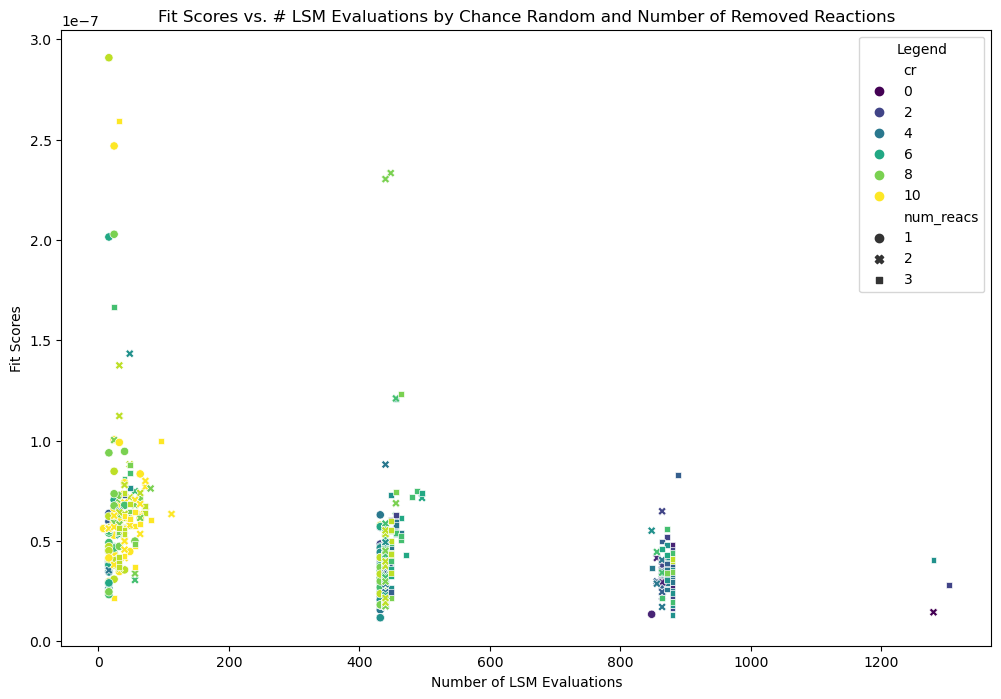

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data from both experiments
all_experiments = []

# Process seed42 results
for _, row in results_df_efm_seed42.iterrows():
    num_reacs = row['num_reacs']
    cr = row['cr']
    df = row['dataframe']
    df['num_reacs'] = num_reacs
    df['cr'] = cr
    df['experiment'] = 'seed42'  # Add experiment identifier
    all_experiments.append(df)

# Process seed17 results
for _, row in results_df_efm_seed17.iterrows():
    num_reacs = row['num_reacs']
    cr = row['cr']
    df = row['dataframe']
    df['num_reacs'] = num_reacs
    df['cr'] = cr
    df['experiment'] = 'seed17'  # Add experiment identifier
    all_experiments.append(df)

# Combine into a single DataFrame
combined_df = pd.concat(all_experiments)

# Scatter Plot: Scores vs. Computation Time by Chance Random and Experiment
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x='Number of LSQ Computations',
    y='Scores',
    hue='cr',  # Differentiate experiments by color
    style='num_reacs',  # Use different markers for num_reacs
    palette='viridis'
)
plt.title('Fit Scores vs. # LSM Evaluations by Chance Random and Number of Removed Reactions')
plt.xlabel('Number of LSM Evaluations')
plt.ylabel('Fit Scores')
plt.legend(title='Legend')
plt.savefig("scatter_scores_vs_time_Combined_Model_SK.png", dpi=300, bbox_inches='tight')
plt.show()




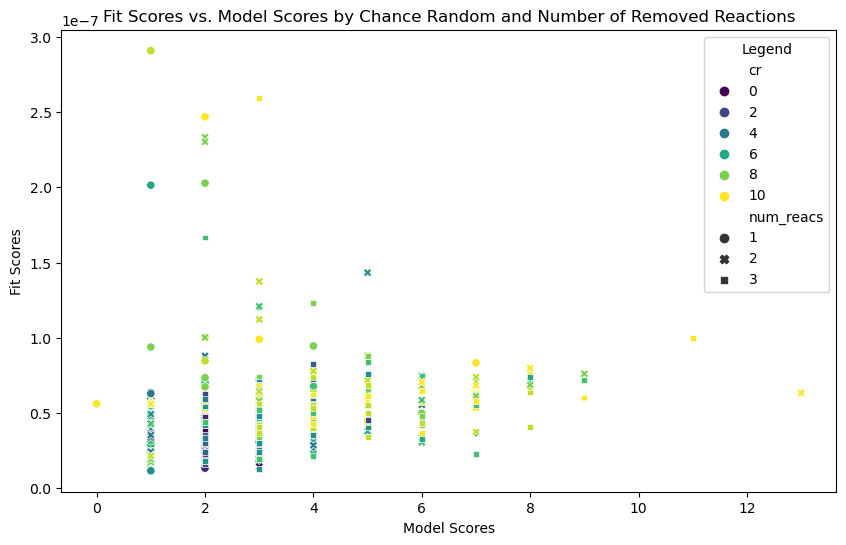

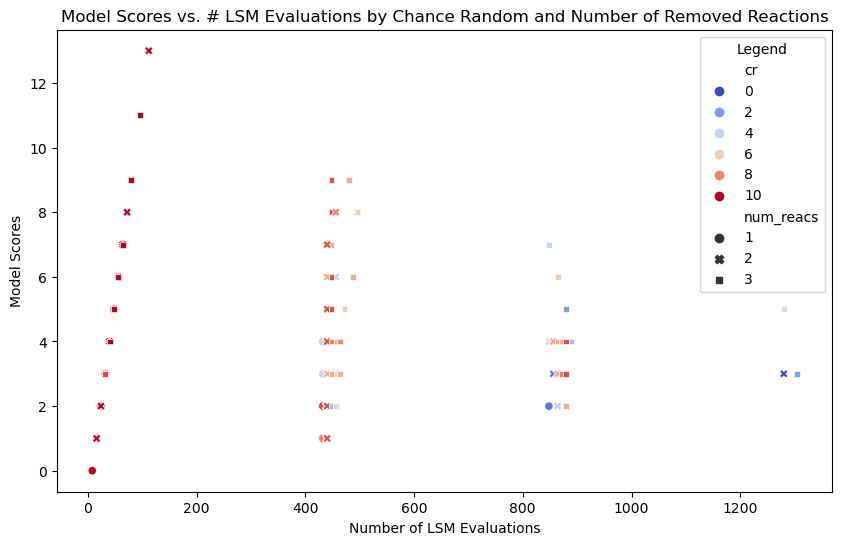

In [88]:
# Scatter Plot: Scores vs. Edit Distances by Temperature and Number of Reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_df,
    x='Edit Distances',
    y='Scores',
    hue='cr',
    style='num_reacs',
    palette='viridis'
)
plt.title('Fit Scores vs. Model Scores by Chance Random and Number of Removed Reactions')
plt.xlabel('Model Scores')
plt.ylabel('Fit Scores')
plt.legend(title='Legend')
plt.savefig("scatter_scores_vs_model_scores_SK.png", dpi=300, bbox_inches='tight')
plt.show()

# Scatter Plot: Edit Distances vs. Computation Times by Temperature and Number of Reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_df,
    x='Number of LSQ Computations',
    y='Edit Distances',
    hue='cr',
    style='num_reacs',
    palette='coolwarm'
)
plt.title('Model Scores vs. # LSM Evaluations by Chance Random and Number of Removed Reactions')
plt.xlabel('Number of LSM Evaluations')
plt.ylabel('Model Scores')
plt.legend(title='Legend')
plt.savefig("scatter_model_scores_vs_computation_time_SK.png", dpi=300, bbox_inches='tight')
plt.show()


In [83]:
# Combining the results from the experiments executed with different random seeds.
merged_evo_df_efm = pd.concat([results_df_efm_seed42, results_df_efm_seed17], ignore_index=True)

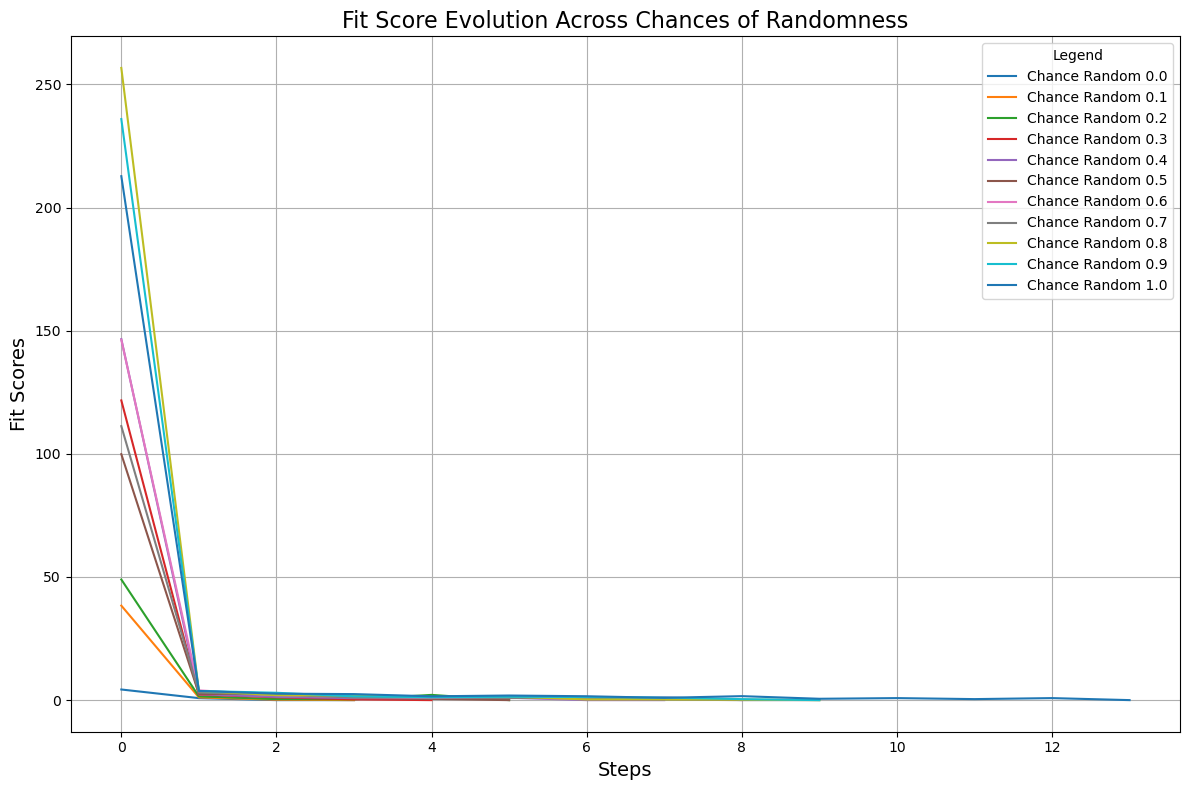

In [84]:
dataframes = merged_evo_df_efm
    
num_reacs_range = range(1,4)    
temp_range = range(0, 11)    
    
plt.figure(figsize=(12, 8))

for temp in temp_range:
    all_scores = []
    max_steps = 0

    for num_reacs in num_reacs_range:
        # Filter for the specific num_reacs and temp
        experiment_df = dataframes[(dataframes['num_reacs'] == num_reacs) & (dataframes['cr'] == temp)]

        if not experiment_df.empty:
            # Access the nested DataFrame for this combination
            for _, row in experiment_df.iterrows():
                nested_df = row['dataframe']  # Access the nested DataFrame
                if 'Score Evolutions' in nested_df.columns:
                    for scores in nested_df['Score Evolutions']:
                        max_steps = max(max_steps, len(scores))
                        all_scores.append(scores)

    # Compute mean scores at each step
    if all_scores:
        score_matrix = np.array(
            [np.pad(s, (0, max_steps - len(s)), constant_values=np.nan) for s in all_scores]
        )
        mean_scores = np.nanmean(score_matrix, axis=0)

        # Plot the mean scores for this temperature
        plt.plot(range(len(mean_scores)), mean_scores, label=f"Chance Random {temp/10}")

plt.xlabel("Steps", fontsize=14)
plt.ylabel("Fit Scores", fontsize=14)
plt.title("Fit Score Evolution Across Chances of Randomness", fontsize=16)
plt.legend(title="Legend", fontsize=10)
plt.grid(True)
plt.tight_layout()  # Sicherstellen, dass das Layout korrekt ist
plt.savefig("lines_scores_vs_steps_SK.png", dpi=300)  # Plot speichern
plt.show()  # Plot schließen    
